## Dataset preparing

In [ ]:
from lxml import etree
from typing import List, Tuple, Optional


def load_sentirueval_2016(file_name: str) -> Tuple[List[str], List[str]]:
    """Load texts and labels from SentiRuEval 2016 XML file."""
    root = _read_xml_file(file_name)
    database = _find_first_database(root)
    texts, labels = _process_database_tables(database, file_name)
    return texts, labels


def _read_xml_file(file_name: str) -> etree._Element:
    with open(file_name, mode='rb') as fp:
        xml_data = fp.read()
    return etree.fromstring(xml_data)


def _find_first_database(root: etree._Element) -> etree._Element:
    """Find first database element in XML tree."""
    for element in root.getchildren():
        if element.tag == 'database':
            return element
    raise ValueError('No database element found in XML')


def _process_database_tables(database: etree._Element, file_name: str) -> Tuple[List[str], List[str]]:
    """Process all tables in database and extract texts and labels."""
    texts = []
    labels = []

    for table in database.getchildren():
        if table.tag != 'table':
            continue

        text, label = _process_table_columns(table)
        _validate_table_data(text, label, file_name)

        texts.append(text)
        labels.append(label)

    return texts, labels


def _process_table_columns(table: etree._Element) -> Tuple[Optional[str], Optional[str]]:
    """Extract text and label from table columns."""
    text = None
    label = None

    for column in table.getchildren():
        column_name = column.get('name')
        column_value = str(column.text).strip() if column.text else ''

        if column_name == 'text':
            text = column_value
        elif column_name not in {'id', 'twitid', 'date'}:
            label = _parse_label(column_value)
            # if column_value in ['1', '0', '-1']:
            #     label = column_value
            # elif column_value == 'NULL':
            #     label = '0'

        if text is not None and label is not None:
            break

    return text, label


def _parse_label(label_str: str) -> Optional[str]:
    """Convert numeric label to textual representation.
       Not nessesary for tf models"""
    if label_str == '-1':
        return 'negative'
    elif label_str == '1':
        return 'positive'
    elif label_str == '0':
        return 'neutral'
    return None

def _validate_table_data(text: Optional[str], label: Optional[str], file_name: str) -> None:
    """Validate that both text and label were found."""
    if text is None or label is None:
        raise ValueError(f'File `{file_name}` contains incomplete data (text or label missing)')


texts, labels = load_sentirueval_2016('bank_train_2016.xml')

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
def convert_labels(labels, label_map):
    new_labels = []
    for label in labels:
        new_label = label_map[label]
        new_labels.append(new_label)
    return new_labels

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
labels = convert_labels(labels, label_map)
labels = to_categorical(labels, num_classes=3) # для pt не использовать

In [ ]:
from sklearn.model_selection import train_test_split

t_texts, test_texts, t_labels, test_labels = train_test_split(texts, labels, test_size=0.2, stratify=labels, random_state=2025)
train_texts, dev_texts, train_labels, dev_labels = t_texts[:5263], t_texts[5263:], t_labels[:5263], t_labels[5263:]

test_samples = [(text, label) for text, label in zip(test_texts, test_labels)]
train_samples = [(text, label) for text, label in zip(train_texts, train_labels)]
dev_samples = [(text, label) for text, label in zip(dev_texts, dev_labels)]

In [ ]:
print('Number of TRAIN texts is {0}, number of labels is {1}.'.format(len(train_texts), len(train_labels)))
print('Number of VAL texts is {0}, number of labels is {1}.'.format(len(dev_texts), len(dev_labels)))
print('Number of TEST texts is {0}, number of labels is {1}.'.format(len(test_texts), len(test_labels)))

## Classes for tf-model

### Preparing model

In [ ]:
import torch
import tensorflow as tf
from transformers import BertModel, BertConfig, BertForSequenceClassification,
                          TFBertForTokenClassification, TFBertForSequenceClassification, BertTokenizer
import copy
from sklearn.model_selection import train_test_split

In [ ]:
def get_model(model_name):
    if model_name == 'tf_bert_for_sequence_classification':
        config = BertConfig.from_pretrained('DeepPavlov/rubert-base-cased', from_pt=True, num_labels=3)
        tf_model = TFBertForSequenceClassification.from_pretrained(
            "DeepPavlov/rubert-base-cased",
            from_pt=True,
            config=config
        )
        #tf_model.layers[-1].activation = tf.keras.activations.softmax
        #tf_model.layers[-1].trainable = True
        return tf_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
tf_model = get_model('tf_bert_for_sequence_classification')
# tf_model.load_weights('/content/drive/MyDrive/weights/senti_classification_3_weights.h5')
tf_model.load_weights('/content/drive/MyDrive/weights/RUbert_cross_domain_main_weights.h5')
tf_model.summary()

Как работает `TFBertForSequenceClassification`:

* На выходе BERT для классификации последовательностей обычно используется специальный токен [CLS], который агрегирует информацию обо всей последовательности.
Вектор, соответствующий этому токену, передаётся в классификатор.

* Слой `tf.keras.layers.Dense`, который добавляется поверх выходных представлений BERT. Он имеет размерность (hidden_size, num_labels) и принимает на вход вектор [CLS] (размерности hidden_size) и преобразует его в вектор размерности num_labels (в данном случае 3).

* На выходе применяется функция softmax, которая преобразует логиты (сырые выходы Dense-слоя) в вероятности классов.

### evaluation full models

In [ ]:
from typing import Any, Tuple, List
import numpy as np

In [ ]:
class Vectorizer:

    def __init__(self):
        self._tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased',
                                                        do_lower_case=False)
        self._max_length = 128

    def vectorize(self, text: str, label: Any) -> Tuple[List[str], List[int], List[int], np.ndarray]:
        try:
            tokenized_text, input_masks = self._tokenize(text)
        except:
            tokenized_text, input_masks = [], []

        input_ids = self._tokenizer.convert_tokens_to_ids(tokenized_text)

        if isinstance(label, np.ndarray):
          tag = label
        else:
          print('Here is the error!')

        input_ids = self._pad(input_ids)
        input_masks = self._pad(input_masks)

        return tokenized_text, input_ids, input_masks, tag

    def _pad(self, input: List[Any]) -> List[Any]:
        if len(input) >= self._max_length:
            return input[:self._max_length]
        while len(input) < self._max_length:
            input.append(0)
        return input

    def _tokenize(self, text: str) -> Tuple[List[str], List[int]]:
        tokenized_text = self._tokenizer.tokenize(text)

        inputs = self._tokenizer.encode_plus(
            tokenized_text,
            is_pretokenized=True,
            return_attention_mask=True,
            max_length=self._max_length,
            truncation=True
        )

        return tokenized_text, inputs['attention_mask']

In [ ]:
vectorizer = Vectorizer()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

class Evaluator_tf:

    def __init__(self, model):
        self._vectorizer = Vectorizer()
        self._model = model
        self._model.training = False
        self._batch_size = 12

    def _predict(self, texts):
        all_labels = []

        for i in range(0, len(texts), self._batch_size):
            batch_texts = texts[i:i + self._batch_size]

            X_ids = []
            X_masks = []
            for text in batch_texts:
                _, input_ids, input_masks, _ = self._vectorizer.vectorize(text, np.zeros([1, 3]))
                X_ids.append(np.array(input_ids))
                X_masks.append(np.array(input_masks))

            input = [np.asarray(X_ids, dtype='int32'), np.asarray(X_masks, dtype='int32')]
            # print("Tensorflow inpyt:", input)
            preds = self._model(input)[0]
            # print("Tensorflow output:", self._model(input))
            max_index = np.argmax(preds, axis=1)
            label_one_hot = np.eye(3)[max_index]
            all_labels.extend(label_one_hot)

        return np.array(all_labels)

    def eval(self, test_texts, test_labels):
        all_y_true = test_labels
        all_y_pred = self._predict(test_texts)

        report = classification_report(all_y_true, all_y_pred, target_names=['negative', 'neutral', 'positive'])
        return report

In [ ]:
evaluator = Evaluator_tf(tf_model)
print(evaluator.eval(test_texts, test_labels))

### get model structure

In [ ]:
# Отображалка имен и размерностей весов на слоях

def print_layer_info(layer):
    print(f"Layer: {layer.name} ({layer.__class__.__name__})")

    if hasattr(layer, 'weights') and layer.weights:
        for i, weight in enumerate(layer.weights):
            print(f"  Weight {i}: {weight.name}, Shape: {weight.shape}")

model = pretrained_model
for layer in model.layers:
    print_layer_info(layer)

## Quantization v1

https://www.tensorflow.org/api_docs/python/tf/compat/v1/quantization

In [ ]:
import copy

In [ ]:
import numpy as np

In [ ]:
quantized_model = copy.deepcopy(tf_model)

In [ ]:
import tensorflow.compat.v1 as tf

In [ ]:
def quantize_weights(layer):
    """
    Квантизирует и де-квантизирует веса слоя.
    """
    # print(layer)
    new_weights = []
    for weight in layer.get_weights():
        weight_tensor = tf.convert_to_tensor(weight, dtype=tf.float32)  # выглядят так tf.Tensor(-0.6931182, shape=(), dtype=float32)

        min_range = tf.reduce_min(weight_tensor)
        max_range = tf.reduce_max(weight_tensor)

        quantized_output = tf.quantization.quantize(
            weight_tensor,
            min_range=min_range,
            max_range=max_range,
            T=tf.qint8,
            mode="SCALED",
            round_mode="HALF_AWAY_FROM_ZERO", # An optional string from: "HALF_AWAY_FROM_ZERO", "HALF_TO_EVEN". Defaults to "HALF_AWAY_FROM_ZERO".
            narrow_range=False,
            # axis=-1,
            ensure_minimum_range=0.1 # 0.001 дало меньшие изменения
        )

        # Де-квантизация обратно в float32 нужна, чтобы модель конфигурировалась и работала
        dequantized_weight = tf.quantization.dequantize(
            quantized_output[0],
            quantized_output[1],
            quantized_output[2],
            mode="MIN_COMBINED",  # An optional string from: "MIN_COMBINED", "MIN_FIRST", "SCALED". Defaults to "MIN_COMBINED".
            narrow_range=False,
            # axis=-1,
            dtype = tf.bfloat16
        )

        new_weights.append(dequantized_weight.numpy())

    layer.set_weights(new_weights)

In [ ]:
def apply_quantization_to_model(model):
    if hasattr(model, 'bert') and hasattr(model.bert, 'encoder'):
        encoder = model.bert.encoder
        for layer in encoder.layer:
            # attention
            if hasattr(layer, 'attention'):
                attention = layer.attention.self_attention
                # query, key, value
                if hasattr(attention, 'query'):
                    quantize_weights(attention.query)
                if hasattr(attention, 'key'):
                    quantize_weights(attention.key)
                if hasattr(attention, 'value'):
                    quantize_weights(attention.value)
                # output dense
            if hasattr(layer.attention, 'output') and hasattr(layer.attention.output, 'dense'):
                    quantize_weights(attention.output.dense)
            # intermediate dense
            if hasattr(layer, 'intermediate') and hasattr(layer.intermediate, 'dense'):
                quantize_weights(layer.intermediate.dense)
            # output dense
            if hasattr(layer, 'output') and hasattr(layer.output, 'dense'):
                quantize_weights(layer.output.dense)

    return model

In [ ]:
apply_quantization_to_model(quantized_model)

In [ ]:
quantized_model.save_weights('rubert_ner_quantized_bfloat16.h5')

### Квантизация с новым модулем tf.quantization.experimental

https://www.tensorflow.org/api_docs/python/tf/quantization/experimental

In [ ]:
tf.saved_model.save(tf_model, '/tmp/input_model')

In [ ]:
from transformers import BertTokenizer
import tensorflow as tf


tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

def create_representative_dataset(texts, tokenizer, num_samples=256):
    max_length = 128
    representative_samples = []

    for text in texts[:num_samples]:
        inputs = tokenizer(
            text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )

        representative_samples.append({
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'token_type_ids': inputs['token_type_ids']
        })

    return representative_samples

representative_samples = create_representative_dataset(dev_texts, tokenizer)

quantization_options = tf.quantization.experimental.QuantizationOptions(
    signature_keys=['serving_default'],
    min_num_elements_for_weights=1024
)

tf.quantization.experimental.quantize_saved_model(
    '/tmp/input_model',
    '/tmp/output_model',
    quantization_options=quantization_options,
    representative_dataset={'serving_default': representative_samples},
)

ОЗУ не хватает, значит, попробуем делить на потоки (upd: cuda не зашла)

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer
import gc

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

def representative_dataset_generator(texts, tokenizer, num_samples=128):
    max_length = 128

    for text in texts[:num_samples]:
        inputs = tokenizer(
            text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )

        yield {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'token_type_ids': inputs['token_type_ids']
        }

        # Очистка памяти после каждого образца
        del inputs
        tf.keras.backend.clear_session()
        gc.collect()

# Использование генератора напрямую (без загрузки всех данных в память)
quantization_options = tf.quantization.experimental.QuantizationOptions(
    signature_keys=['serving_default'],
    min_num_elements_for_weights=1024
)

tf.quantization.experimental.quantize_saved_model(
    '/tmp/input_model',
    '/tmp/output_model',
    quantization_options=quantization_options,
    representative_dataset={'serving_default': representative_dataset_generator(texts, tokenizer)},
)

### time eval & save model

In [ ]:
import time
import numpy as np

vectorizer = Vectorizer()
X_ids = []
X_masks = []
for text in test_texts[:50]:
    _, input_ids, input_masks, _ = vectorizer.vectorize(text, np.zeros([1, 3]))
    X_ids.append(np.array(input_ids))
    X_masks.append(np.array(input_masks))

input_data = [np.asarray(X_ids, dtype='int32'), np.asarray(X_masks, dtype='int32')]
X_ids = np.asarray(X_ids, dtype='int32')
X_masks = np.asarray(X_masks, dtype='int32')

for model in [tf_model, clustered_classification]:
  preds = model(input_data)[0]
  max_index = np.argmax(preds, axis=1)
  label_one_hot = np.eye(3)[max_index]

  execution_times = []

  for i in range(50):
      start_time = time.time()
      model.predict([X_ids[i:i+1], X_masks[i:i+1]], verbose=0)
      end_time = time.time()
      execution_times.append(end_time - start_time)

  # Вычисляем среднее время выполнения
  average_execution_time = np.mean(execution_times)

  print(f"Среднее время выполнения predict: {average_execution_time:.4f} секунд")

А для NER:

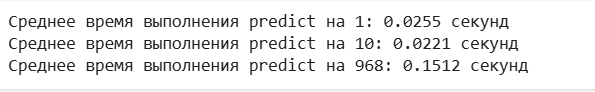

В таком виде модель, конечно, не занимает меньше места

Поэтому сохраняем модель в формате TFLite с квантизацией

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

In [ ]:
import os
original_size = os.path.getsize('my_rubert_quantized.h5')
quantized_size = os.path.getsize('quantized_model.tflite')
print(f"Original model size: {original_size} bytes")
print(f"Quantized model size: {quantized_size} bytes")

квантование — это необратимое сжатие.

Эти модели предназначены для выполнения инференса на устройствах с поддержкой TFLite

Где работают квантованные модели?
* int8/uint8:

  * CPU/GPU с поддержкой INT8 (например, ARM NEON, x86 AVX2).

  * Ускорители типа Google Edge TPU, NVIDIA TensorRT.

* float16:

  * GPU с поддержкой FP16 (мобильные GPU, NVIDIA).

* float32:

  * Любое устройство с поддержкой TFLite.

(однако все ещё есть библиотека tflite2tensorflow)

К изучению:

см. туториал
https://ai.google.dev/edge/litert/models/post_training_integer_quant

и

https://ai.google.dev/edge/litert/models/post_training_quantization

Динамическая квантизация: Применяется с использованием `converter.optimizations = [tf.lite.Optimize.DEFAULT]`. Это квантует только веса модели.

Полная квантизация: Для квантизации активаций используется representative_dataset, который предоставляет примеры входных данных для оценки диапазона значений активаций. Это позволяет квантовать и веса, и активации.

Целочисленная квантизация: Дополнительно задаются параметры `converter.inference_input_type = tf.uint8` и `converter.inference_output_type = tf.uint8`, чтобы входные и выходные данные также были целочисленными.

Можно визуализировать распределение весов до и после квантизации, чтобы увидеть, как изменились значения.

In [ ]:
import matplotlib.pyplot as plt

original_model = tf_model

def plot_weight_distribution(weights, title):
    plt.hist(weights.flatten(), bins=50, alpha=0.7)
    plt.title(title)
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.show()

# Визуализация оригинальных весов
for layer in original_model.layers:
    if hasattr(layer, 'weights') and layer.weights:
        weights = layer.get_weights()[0]
        plot_weight_distribution(weights, f"Original weights of {layer.name}")

# Визуализация квантизированных весов
for layer in quantized_model.layers:
    if hasattr(layer, 'weights') and layer.weights:
        weights = layer.get_weights()[0]
        plot_weight_distribution(weights, f"Quantized weights of {layer.name}")

## GPTQ

In [ ]:
!pip install --upgrade accelerate optimum transformers

In [ ]:
!pip install gptqmodel --no-build-isolation

In [ ]:
!pip install gptqmodel

In [ ]:
import torch
from transformers import BertModel, BertConfig, BertForSequenceClassification, BertTokenizer, GPTQConfig, AutoModelForCausalLM

In [ ]:
from optimum.gptq import GPTQQuantizer
# from auto_gptq import GPTQQuantizer

### Preparing model

In [ ]:
# PyTorch!!
config = BertConfig.from_pretrained('DeepPavlov/rubert-base-cased', from_pt=True, num_labels=3)
pt_model = BertForSequenceClassification.from_pretrained(
            "DeepPavlov/rubert-base-cased",
            config=config)

In [ ]:
# pt_model.config._attn_implementation = "eager"

In [ ]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', do_lower_case=False)

In [ ]:
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

### gptquantization

In [ ]:
gptq_config = GPTQConfig(
    bits=4,
    dataset=text_list,
    tokenizer=tokenizer,
    batch_size=8,
    use_cuda=True,
    pad_token_id=tokenizer.pad_token_id
)

In [ ]:
from transformers import GPTQConfig, BertLMHeadModel
from optimum.gptq import GPTQQuantizer

In [ ]:
quantized_model = AutoModelForCausalLM.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    device_map="auto",
    max_memory={0: "30GiB", 1: "46GiB", "cpu": "30GiB"},
    quantization_config=gptq_config
)

In [ ]:
model = BertModel.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    is_decoder=True
)

quantizer = GPTQQuantizer(
    bits=4,
    dataset=val_texts,
    tokenizer=tokenizer,
    batch_size=8,
    # use_cuda=True,
    pad_token_id=tokenizer.pad_token_id
)

quantized_model = quantizer.quantize(model)

In [ ]:
quantized_model = BertModel.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    device_map="auto",
    quantization_config=gptq_config,
)

quantized_model.summary()